<a href="https://colab.research.google.com/github/umairaziz999/BERT-Style-LLM-Assignment/blob/main/LLM_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**
In this document, we discuss the process of fine-tuning the mbart-50 model using personalized data for translating English to Urdu. We'll guide you through every step, from data preparation to model input. Our setup involves the utilization of 2 T4 GPUs for this task.

In [4]:
!pip install datasets
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 4.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-

In [5]:
import datasets
import csv
import os
from datasets import concatenate_datasets,Dataset
import pandas as pd
from datasets import Dataset
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer,MBartForConditionalGeneration
from transformers import DataCollatorForSeq2Seq
import shutil
from huggingface_hub import notebook_login
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer,TrainingArguments, Trainer
import gc
from transformers import MBartForConditionalGeneration, AutoTokenizer,pipeline

# **Data Preparation**
For this task, we'll utilize the "opus100" dataset available on Hugging Face. This dataset comprises 753,913 text samples in both English and Urdu. Initially, I convert the data into CSV format for ease of handling since I'm proficient with CSVs. Additionally, I limit the dataset to 6,000 samples (5,000 for training and 1,000 for validation) due to the time required for training the model. Below, I've detailed each of these steps in sequential code.

In [6]:
dataset = datasets.load_dataset("opus100",'en-ur')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/753913 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [7]:
def save_translation_to_csv(input_dict, output_file):
    # Extract English and Urdu texts from the input dictionary
    english_text = input_dict['translation']['en']
    urdu_text = input_dict['translation']['ur']

    # Create a list of dictionaries containing the data to be saved in the CSV file
    data = [{'Urdu': urdu_text, 'English': english_text}]

    # Define the CSV file headers
    fieldnames = ['Urdu', 'English']

    # Check if the CSV file already exists
    file_exists = os.path.isfile(output_file)

    # Write the data to the CSV file
    with open(output_file, 'a', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Write header only if the file is newly created
        if not file_exists:
            writer.writeheader()

        # Write the data row
        writer.writerows(data)


In [8]:
output_csv_file = 'translation.csv'
for n in range(6000):
   input_text=dataset['train'][n]
   save_translation_to_csv(input_text, output_csv_file)

# **Loading Data**
Next, we proceed to load the data and prepare it for model input. I've devised five distinct styles of prompts. By "different styles of prompts," I refer to five varied methods of posing questions to the model and receiving answers from it. Considering that users may inquire in diverse manners, I've formulated these five approaches. You can modify the prompts or increase their variety based on the subset of data you're utilizing.

In [9]:
dataset_file1 = '/content/translation.csv'
dataset1 = pd.read_csv(dataset_file1)


In [10]:
dataset1

,Urdu,English
0,اورجب ہم نے موسیٰ سے چالیس رات کا وعدہ کیا پھر...,"Yet, remember, as We communed with Moses for f..."
1,"بجز تیرے اُن بندوں کے جنہیں تو نے خالص کر لیا ہے""","Except, among them, Your chosen servants."""
2,(اے پیغمبر لوگوں سے) کہہ دو کہ میرے پاس وحی آئ...,"Say, (O Prophet), it was revealed to me that a..."
3,ہم عنقریب اس کی ناک پر داغ لگائیں گے,Soon We shall brand him on his snout.
4,اور جو لوگ مومن مردوں اور عورتوں کو بے قصور اذ...,And those who unnecessarily harass Muslim men ...
...,...,...
5995,اور ہم نے انہیں بانٹ دیا بارہ قبیلے گروہ گروہ،...,We divided them into twelve tribal communities...
5996,جو تمہارا بھی پروردگار ہے اور تمہارے پہلے والے...,who is your Lord and the Lord of your forefath...
5997,تاکہ وہ اس کے پھل کھائیں اور اسے اُن کے ہاتھوں...,So that they may eat of its fruit; yet it was ...
5998,اتنے میں شہر کے دُور دراز گوشے سے ایک شخص دوڑت...,"Then there came running, from the farthest par..."


In [11]:
train_dataset=dataset1[:100]
val_dataset=dataset1[100:200]

In [12]:
val_dataset.shape

(100, 2)

Here we are dividing the 500 train samples into 5 parts 100 samples for a single type of prompt

In [13]:
data1=train_dataset[:20]
data2=train_dataset[20:40]
data3=train_dataset[40:60]
data4=train_dataset[60:80]
data5=train_dataset[80:100]

Here i am creating a different dataset object and filling it by creating a prompt along with the data.Here engtext colomn is the source colomn and urdutext colomn is the target colomn

In [14]:
train_dataset1 = pd.DataFrame()
train_dataset1['engtext'] ='Can you translate "' + data1['English'] + '" into urdu ?'
train_dataset1['urdutext'] = 'Yes sure here is the urdu translation "' + data1['Urdu'] + '".'

train_dataset2 = pd.DataFrame()
train_dataset2['engtext'] = 'Please Translate "' + data2['English'] + '" to urdu.'
train_dataset2['urdutext'] = 'Okey the translation into urdu is "' + data2['Urdu'] + '". I hope this will help.'

train_dataset3 = pd.DataFrame()
train_dataset3['engtext'] = 'Please Translate "' + data3['English'] + '" to urdu.'
train_dataset3['urdutext'] = "Yeah sure i can help you with that here is the translation in Urdu : " + data3['Urdu'] + '.'

train_dataset4 = pd.DataFrame()
train_dataset4['engtext'] = 'Can you translate "' + data4['English'] + '" into urdu ?'
train_dataset4['urdutext'] = 'Yes, the translation of "' + data4['English'] + '" to Urdu is : "' + data4['Urdu'] + '".'

train_dataset5 = pd.DataFrame()
train_dataset5['engtext'] = 'Translate English text to Urdu. Here is the text :"' + data5['English'] + '".'
train_dataset5['urdutext'] = 'Sure, the translation of your given text to Urdu is : "' + data5['Urdu'] + '".'

appended_dataframe = pd.concat([train_dataset1, train_dataset2, train_dataset3, train_dataset4, train_dataset5], ignore_index=True)

train_data = Dataset.from_pandas(appended_dataframe)
train_data

Dataset({
    features: ['engtext', 'urdutext'],
    num_rows: 100
})

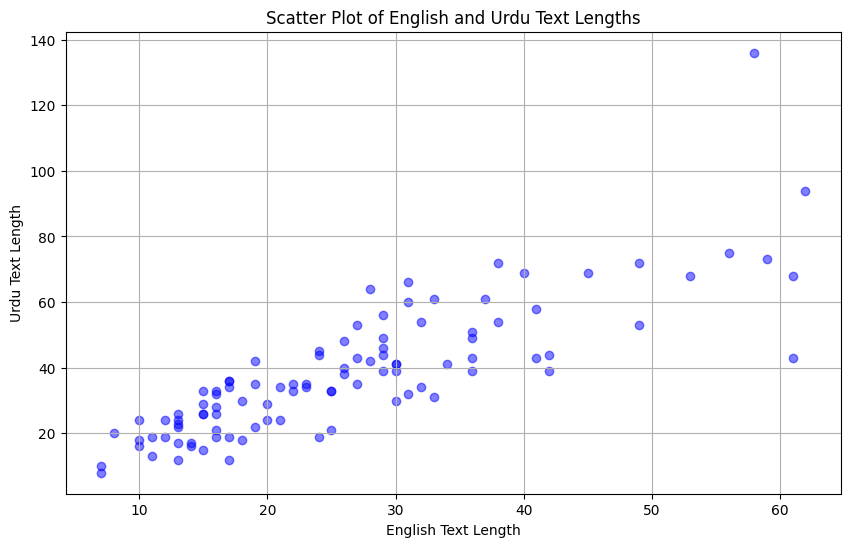

In [16]:
import matplotlib.pyplot as plt
# Concatenate all datasets
appended_dataframe = pd.concat([train_dataset1, train_dataset2, train_dataset3, train_dataset4, train_dataset5], ignore_index=True)

# Calculate length of English and Urdu texts
appended_dataframe['eng_length'] = appended_dataframe['engtext'].apply(lambda x: len(x.split()))
appended_dataframe['urdu_length'] = appended_dataframe['urdutext'].apply(lambda x: len(x.split()))

# Plot scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(appended_dataframe['eng_length'], appended_dataframe['urdu_length'], color='blue', alpha=0.5)
plt.title('Scatter Plot of English and Urdu Text Lengths')
plt.xlabel('English Text Length')
plt.ylabel('Urdu Text Length')
plt.grid(True)
plt.show()

In [ ]:
train_data['engtext'][4]

'Can you translate "And those who unnecessarily harass Muslim men and women, have burdened themselves with slander and open sin." into urdu ?'

In [ ]:
train_data['urdutext'][4]

'Yes sure here is the urdu translation "اور جو لوگ مومن مردوں اور عورتوں کو بے قصور اذیت دیتے ہیں اُنہوں نے ایک بڑے بہتان اور صریح گناہ کا وبال اپنے سر لے لیا ہے".'

In [ ]:
data1=val_dataset[:20]
data2=val_dataset[20:40]
data3=val_dataset[40:60]
data4=val_dataset[60:80]
data5=val_dataset[80:100]

In [ ]:
val_dataset1 = pd.DataFrame()
val_dataset1['engtext'] ='Can you translate "' + data1['English'] + '" into urdu ?'
val_dataset1['urdutext'] = 'Yes sure here is the urdu translation "' + data1['Urdu'] + '".'

val_dataset2 = pd.DataFrame()
val_dataset2['engtext'] = 'Please Translate "' + data2['English'] + '" to urdu.'
val_dataset2['urdutext'] = 'Okey the translation into urdu is "' + data2['Urdu'] + '". I hope this will help.'

val_dataset3 = pd.DataFrame()
val_dataset3['engtext'] = 'Please Translate "' + data3['English'] + '" to urdu.'
val_dataset3['urdutext'] = "Yeah sure i can help you with that here is the translation in Urdu : " + data3['Urdu'] + '.'

val_dataset4 = pd.DataFrame()
val_dataset4['engtext'] = 'Can you translate "' + data4['English'] + '" into urdu ?'
val_dataset4['urdutext'] = 'Yes, the translation of "' + data4['English'] + '" to Urdu is : "' + data4['Urdu'] + '".'

val_dataset5 = pd.DataFrame()
val_dataset5['engtext'] = 'Translate English text to Urdu. Here is the text :"' + data5['English'] + '".'
val_dataset5['urdutext'] = 'Sure, the translation of your given text to Urdu is : "' + data5['Urdu'] + '".'

appended_dataframe = pd.concat([val_dataset1, val_dataset2, val_dataset3, val_dataset4, val_dataset5], ignore_index=True)

val_data = Dataset.from_pandas(appended_dataframe)
val_data


Dataset({
    features: ['engtext', 'urdutext'],
    num_rows: 100
})

In [ ]:
val_data['engtext'][4]

'Can you translate "On that day they follow the summoner who deceiveth not, and voices are hushed for the Beneficent, and thou hearest but a faint murmur." into urdu ?'

In [ ]:
val_data['urdutext'][4]

'Yes sure here is the urdu translation "اس دن پکارےنے والے کا اتباع کریں گے اس میں کوئی کجی نہیں ہوگی اور رحمان کے ڈر سے آوازیں دب جائیں گی پھر تو پاؤں کی آہٹ کے سوا کچھ نہیں سنے گا".'

# **Loading the model**

In [ ]:
model_ckpt = "facebook/mbart-large-50"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = MBartForConditionalGeneration.from_pretrained(model_ckpt)

We're about to craft a function tasked with transforming the text data into input IDs and labels. Since computers comprehend numbers rather than text, we must convert the text into numerical representations. To accomplish this, we'll employ the mbart tokenizer. The maximum length is set to 1024, aligning with the maximum number of tokens mbart can process in one go.

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["engtext"], max_length=1024, padding="max_length",truncation=True)

    #with tokenizer.as_target_tokenizer():
    target_encodings = tokenizer(example_batch["urdutext"], max_length=1024, padding="max_length", truncation=True)

    return {"input_ids": input_encodings["input_ids"],
           "attention_mask": input_encodings["attention_mask"],
           "labels": target_encodings["input_ids"]}

train_dataset_tf = train_data.map(convert_examples_to_features, batched=True, remove_columns=["engtext","urdutext"])
val_dataset_tf = val_data.map(convert_examples_to_features, batched=True, remove_columns=["engtext","urdutext"])

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
train_dataset_tf

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})

In [ ]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
notebook_login()

In [ ]:
training_args = Seq2SeqTrainingArguments(output_dir='mbartTrans', num_train_epochs=2,
                                  per_device_train_batch_size=1, per_device_eval_batch_size=1,
                                evaluation_strategy='steps',save_strategy='no',eval_steps=2,logging_steps=10,
                                  weight_decay=0.01, push_to_hub=False,
                           learning_rate=2e-5,optim="adafactor")

In [ ]:
gc.collect()

38

In [ ]:
trainer = Seq2SeqTrainer(model=model, args=training_args, tokenizer=tokenizer,
                  data_collator=seq2seq_data_collator,
                  train_dataset=train_dataset_tf,
                        eval_dataset=val_dataset_tf)

trainer.train()

Step,Training Loss,Validation Loss
2,No log,11.812526
4,No log,11.337551
6,No log,11.202165
8,No log,10.638989
10,11.446800,10.156157
12,11.446800,9.736961
14,11.446800,9.355163
16,11.446800,9.095414
18,11.446800,8.759762
20,9.642100,8.482137


TrainOutput(global_step=200, training_loss=3.5970665788650513, metrics={'train_runtime': 4965.8012, 'train_samples_per_second': 0.04, 'train_steps_per_second': 0.04, 'total_flos': 433425953587200.0, 'train_loss': 3.5970665788650513, 'epoch': 2.0})

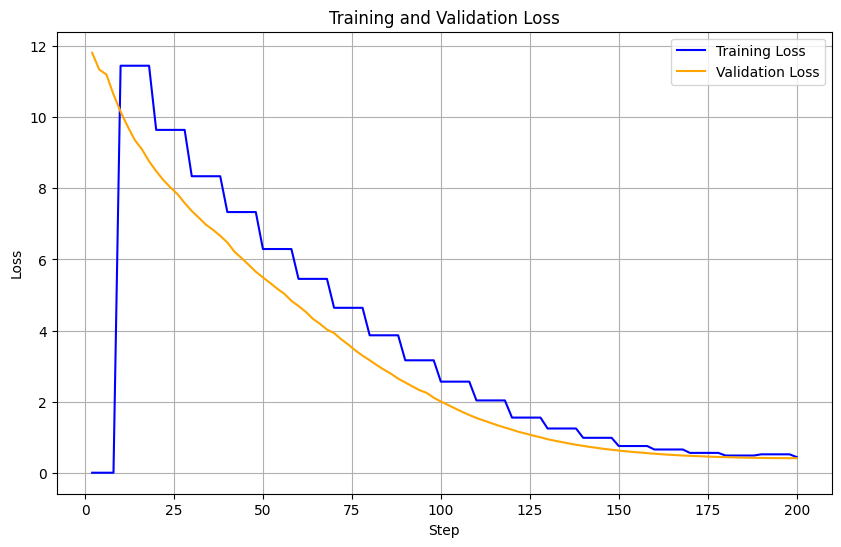

In [ ]:
import matplotlib.pyplot as plt

# Data
steps = range(2, 201, 2)  # Steps from 2 to 200
training_loss = [0,0,0,0,11.446800, 11.446800, 11.446800, 11.446800, 11.446800, 9.642100, 9.642100, 9.642100, 9.642100, 9.642100,
                 8.338600, 8.338600, 8.338600, 8.338600, 8.338600, 7.331100, 7.331100, 7.331100, 7.331100, 7.331100,
                 6.291600, 6.291600, 6.291600, 6.291600, 6.291600, 5.452000, 5.452000, 5.452000, 5.452000, 5.452000,
                 4.638200, 4.638200, 4.638200, 4.638200, 4.638200, 3.865200, 3.865200, 3.865200, 3.865200, 3.865200,
                 3.161700, 3.161700, 3.161700, 3.161700, 3.161700, 2.561600, 2.561600, 2.561600, 2.561600, 2.561600,
                 2.033200, 2.033200, 2.033200, 2.033200, 2.033200, 1.550600, 1.550600, 1.550600, 1.550600, 1.550600,
                 1.243900, 1.243900, 1.243900, 1.243900, 1.243900, 0.981700, 0.981700, 0.981700, 0.981700, 0.981700,
                 0.750600, 0.750600, 0.750600, 0.750600, 0.750600, 0.653300, 0.653300, 0.653300, 0.653300, 0.653300,
                 0.557700, 0.557700, 0.557700, 0.557700, 0.557700, 0.483700, 0.483700, 0.483700, 0.483700, 0.483700,
                 0.517400, 0.517400, 0.517400, 0.517400, 0.517400, 0.440200]  # Training loss
validation_loss = [11.812526, 11.337551, 11.202165, 10.638989, 10.156157, 9.736961, 9.355163, 9.095414, 8.759762, 8.482137,
                   8.233141, 8.022139, 7.835227, 7.585867, 7.361290, 7.170330, 6.975004, 6.828532, 6.662898, 6.475749,
                   6.215707, 6.036860, 5.846663, 5.652573, 5.492023, 5.340014, 5.176967, 5.032942, 4.834529, 4.687957,
                   4.528193, 4.332263, 4.189284, 4.026888, 3.926549, 3.752860, 3.604084, 3.437669, 3.292140, 3.163546,
                   3.026082, 2.899587, 2.782542, 2.646453, 2.537758, 2.429250, 2.321382, 2.246531, 2.109496, 2.002630,
                   1.906409, 1.808191, 1.711494, 1.623008, 1.539780, 1.470008, 1.401267, 1.332217, 1.270664, 1.209563,
                   1.146172, 1.096671, 1.042419, 0.996626, 0.941289, 0.900988, 0.861473, 0.821872, 0.787129, 0.754971,
                   0.722991, 0.696847, 0.668432, 0.645933, 0.623963, 0.602736, 0.583926, 0.569016, 0.549957, 0.534384,
                   0.520357, 0.507387, 0.495521, 0.483993, 0.474451, 0.466081, 0.458962, 0.449893, 0.443370, 0.437809,
                   0.431877, 0.426471, 0.422676, 0.418891, 0.415755, 0.413246, 0.411349, 0.409890, 0.408980, 0.408572]  # Validation loss

# Define the steps array to match the length of the training_loss array
steps = range(2, 201, 2)  # Steps from 2 to 200
steps = list(steps)[:len(training_loss)]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(steps, training_loss, label='Training Loss', color='blue')
plt.plot(steps, validation_loss, label='Validation Loss', color='orange')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
trainer.save_model("mbartfortranslation5000")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


In [ ]:
shutil.make_archive('mbartfortranslation', 'zip', '/content/mbartfortranslation5000')

'/content/mbartfortranslation.zip'

> # **Testing the model on custom prompts**

Note: Sure, before we proceed with restarting and clearing the cell output, let's save the notebook to ensure that none of your work is lost. Once saved, we'll execute the restart and clear cell output command to release the GPU memory.

In [ ]:
model_ckpt = "/content/mbartfortranslation5000"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForCausalLM.from_pretrained("/content/mbartfortranslation5000").to('cuda:0').half()

Some weights of MBartForCausalLM were not initialized from the model checkpoint at /content/mbartfortranslation5000 and are newly initialized: ['lm_head.weight', 'model.decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
prompt1='Please Translate "How are you." to urdu.'
prompt1

'Please Translate "How are you." to urdu.'

In [ ]:
generator = pipeline('text2text-generation', model=model, tokenizer=tokenizer,forced_bos_token_id = tokenizer.lang_code_to_id ["ur_PK"],device='cuda:0',do_sample=False)

The model 'MBartForCausalLM' is not supported for text2text-generation. Supported models are ['BartForConditionalGeneration', 'BigBirdPegasusForConditionalGeneration', 'BlenderbotForConditionalGeneration', 'BlenderbotSmallForConditionalGeneration', 'EncoderDecoderModel', 'FSMTForConditionalGeneration', 'GPTSanJapaneseForConditionalGeneration', 'LEDForConditionalGeneration', 'LongT5ForConditionalGeneration', 'M2M100ForConditionalGeneration', 'MarianMTModel', 'MBartForConditionalGeneration', 'MT5ForConditionalGeneration', 'MvpForConditionalGeneration', 'NllbMoeForConditionalGeneration', 'PegasusForConditionalGeneration', 'PegasusXForConditionalGeneration', 'PLBartForConditionalGeneration', 'ProphetNetForConditionalGeneration', 'SeamlessM4TForTextToText', 'SeamlessM4Tv2ForTextToText', 'SwitchTransformersForConditionalGeneration', 'T5ForConditionalGeneration', 'UMT5ForConditionalGeneration', 'XLMProphetNetForConditionalGeneration'].


In [ ]:
result = generator(prompt1, max_length=16)

In [ ]:
result

[{'generated_text': 'Please Translate "How are you." to urdu. diskuse тижні'}]